In [2]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import configs.config as cfg
def overlap_percentage(A, B):
    """Calculates the % of pixels in A (nucleus) that overlap with B (cell)."""
    overlap = np.sum(A & B)  # Element-wise AND, counts overlapping 1s
    total_A = np.sum(A)      # Total 1s in A
    return (overlap / total_A) * 100 if total_A > 0 else 0  # Avoid division by zero

# Loading single cell stats and transformed matrix
df = pd.read_csv(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/transformed_matrix.csv", index_col=0).iloc[:,:6]
meta = pd.read_csv(f"{cfg.PROJECT_DIR}/cell_nu_ratio.txt")
res = []
for imgpath in meta.image_path:
    data = np.load(imgpath.replace('/scratch/users/tle1302/2Dshapespace', '/data/2Dshapespace'))
    res.append(overlap_percentage(data[1,:,:], data[0,:,:]))
meta['nucleus_inside_cell'] = res
meta = meta[(meta.cell_nu_ratio < 8) & (meta.cell_nu_ratio > 1) & (meta.nucleus_inside_cell > 90)]
print(df.shape)
df = df[df.index.isin(meta.image_path)]
print(df.shape)

(31259, 6)
(29760, 6)


In [3]:
meta = pd.read_csv(f"{cfg.PROJECT_DIR}/cell_nu_ratio.txt")
meta['Protein'] = meta.image_path.apply(lambda x: x.split('/')[-3])
meta.groupby('Protein').size()

Protein
CAB079904_USP7      283
CAB079921_PPP1CC    413
CAB080425_KAT2A     384
CAB080426_HDAC8     434
CAB080427_HDAC11    394
                   ... 
HPA074736_KMT2C     401
HPA076218_PRKAG3    284
HPA076873_BRD3      150
HPA077805_PRKAG1    363
NEGATIVE_CTRL       121
Length: 96, dtype: int64

In [18]:
#import matplotlib.pyplot as plt
#data = np.load('/data/2Dshapespace/B2AI/cell_masks/HPA044540_PRKAA2/B2AI_1_Vorinostat_C7_R8/4.npy')
#plt.imshow(data[0,:,:], alpha=0.5)
#plt.imshow(data[1,:,:], alpha=0.5)

# Shape match

In [4]:
from scipy.spatial.distance import cdist
df['Proteins'] = [f.split('/')[-3] for f in df.index]
df['treatment'] = [f.split('/')[-2].split('_')[2] for f in df.index]
diff = []
labels = []
proteins = []
img_paths = []
for (ab, df_) in df.groupby('Proteins'):
    if ab == 'NEGATIVE_CTRL':
        continue
    shape_d = {}
    shape_d['untreated'] = df_[df_.index.str.contains('untreated')]
    shape_d['vorinostat'] = df_[df_.index.str.contains('Vorinostat')]
    shape_d['paclitaxel'] = df_[df_.index.str.contains('Paclitaxel')]
    distances = cdist(shape_d['untreated'][['PC1','PC2','PC3','PC4','PC5','PC6']], shape_d['vorinostat'][['PC1','PC2','PC3','PC4','PC5','PC6']])
    # find pair of cells that are closest to each other in shape_d
    pairwise_indices = np.argmin(distances, axis=0)  # Get index of closest untreated cell for each treated
    # Collect the closest pairs of indices
    for j, i in enumerate(pairwise_indices):
        imgpath_untreated = shape_d['untreated'].index[i]
        names = imgpath_untreated.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr0 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")

        imgpath_vorinostat = shape_d['vorinostat'].index[j]
        names = imgpath_vorinostat.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr1 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        diff.append((pilr1-pilr0).flatten())
        proteins.append(ab)
        labels.append('vorinostat')
        img_paths.append(shape_d['vorinostat'].index[j])

    distances = cdist(shape_d['untreated'][['PC1','PC2','PC3','PC4','PC5','PC6']], shape_d['paclitaxel'][['PC1','PC2','PC3','PC4','PC5','PC6']])
    # find pair of cells that are closest to each other in shape_d
    pairwise_indices = np.argmin(distances, axis=0)  # Get index of closest untreated cell for each treated
    # Collect the closest pairs of indices
    for j, i in enumerate(pairwise_indices):
        imgpath_untreated = shape_d['untreated'].index[i]
        names = imgpath_untreated.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr0 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")

        imgpath_paclitaxel = shape_d['paclitaxel'].index[j]
        names = imgpath_paclitaxel.split('/')
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr1 = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        diff.append((pilr1-pilr0).flatten())
        proteins.append(ab)
        labels.append('paclitaxel')
        img_paths.append(shape_d['paclitaxel'].index[j])

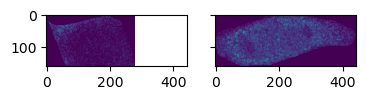

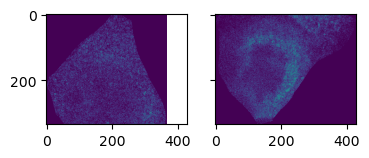

In [5]:
from matplotlib import pyplot as plt

for j, i in enumerate(pairwise_indices[38:40]):
    fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex=True, sharey=True)
    imgpath_untreated = shape_d['untreated'].index[i]
    names = imgpath_untreated.split('/')
    ax[0].imshow(plt.imread(f"{cfg.PROJECT_DIR}/cell_masks/{names[-3]}/{names[-2]}/{names[-1][:-4]}_protein.png"))

    imgpath_paclitaxel = shape_d['paclitaxel'].index[j]
    names = imgpath_paclitaxel.split('/')
    ax[1].imshow(plt.imread(f"{cfg.PROJECT_DIR}/cell_masks/{names[-3]}/{names[-2]}/{names[-1][:-4]}_protein.png"))

In [6]:
protein = "NEGATIVE_CTRL"

shape_d = {}
shape_d['untreated'] = df[~df.index.str.contains(protein) & df.index.str.contains('untreated')]
shape_d['vorinostat'] = df[~df.index.str.contains(protein) & df.index.str.contains('Vorinostat')]
shape_d['paclitaxel'] = df[~df.index.str.contains(protein) & df.index.str.contains('Paclitaxel')]
print([(k, v.shape) for k, v in shape_d.items()])

def stack_pilr(df):
    pilr = []
    proteins = []
    for imgpath in df.index:
        names = imgpath.split('/')
        proteins.append(names[-3])
        img_id = '_'.join([names[-3], names[-2], names[-1]]).replace('.npy', '_protein.npy')
        pilr_ = np.load(f"{cfg.PROJECT_DIR}/sampled_intensity_bin/{img_id}")
        #print(pilr_.max(), pilr_)
        #brekame
        #pilr_ = (pilr_ >= np.percentile(pilr_, 80)).astype(float)
        pilr.append(pilr_.flatten())
    return np.stack(pilr), proteins

pilr_d = {}
pilr_d['untreated'], proteins_untreated = stack_pilr(shape_d['untreated'])
pilr_d['vorinostat'], proteins_vorinostat = stack_pilr(shape_d['vorinostat'])
pilr_d['paclitaxel'], proteins_paclitaxel = stack_pilr(shape_d['paclitaxel'])

[('untreated', (15086, 8)), ('vorinostat', (4484, 8)), ('paclitaxel', (10090, 8))]


## UMAP and Leiden to get similar group of responses

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import igraph as ig
import leidenalg as la
from sklearn.neighbors import NearestNeighbors
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def run_and_plot_umap(alldata, labels):
    reducer=umap.UMAP(n_neighbors=30, min_dist= 0.01, n_components=3, metric='euclidean')
    embedding = reducer.fit_transform(alldata)
    plt.figure(figsize=(5,5))
    sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue=labels, s=5)
    return embedding

def reduce_dimensionality(data, method='umap', n_components=10):
    """Reduce dimensionality of the feature matrix using PCA or UMAP."""
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'umap'")
    reduced_data = reducer.fit_transform(data)
    if method == 'pca':
        print(f"Explained variance: {reducer.explained_variance_ratio_}")
    return reduced_data

def build_knn_graph(data, n_neighbors=15):
    """Construct a k-nearest neighbor graph from the data using a sparse matrix."""
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
    knn_graph = nbrs.kneighbors_graph(data, mode='connectivity')  # Sparse matrix
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(edges=list(zip(sources, targets)), directed=False)
    g.vs["name"] = list(range(data.shape[0]))  # Assign node IDs
    return g

if True:
    labels_df = pd.DataFrame({'Proteins': proteins, 'Treatment': labels, 'Image': img_paths})
    labels_df['Protein'] = [f.split('_')[1] for f in labels_df.Proteins]
    treatment = 'paclitaxel' #'vorinostat'
    reduced_data = reduce_dimensionality(np.array(diff)[labels_df.Treatment==treatment], method='pca', n_components=3)
    labels_df = labels_df[labels_df.Treatment==treatment]
    labels_df['PC1'] = reduced_data[:, 0]
    labels_df['PC2'] = reduced_data[:, 1]

'''
resolutions = [0, 0.4, 1]
neighbors = [5, 20, 40]
current_data = reduced_data.copy()  # To ensure no overwriting
current_labels = None
for res, n_neighbors in zip(resolutions, neighbors):
    print(f"n_neighbors={n_neighbors}")
    graph = build_knn_graph(reduced_data, n_neighbors=n_neighbors)
    partition = la.find_partition(graph, la.RBConfigurationVertexPartition, resolution_parameter=res)
    print(f"Number of clusters: {len(set(partition.membership))}")
    print(f"Modularity: {partition.modularity}")
    # 5. Extract Cluster Labels
    #cluster_labels = np.array(partition.membership)
    labels_df[f'Cluster_res{res}_neigh{n_neighbors}'] = partition.membership
    print(labels_df.groupby(f'Cluster_res{res}_neigh{n_neighbors}').Protein.nunique())
'''

Explained variance: [0.52335051 0.14654201 0.01668499]


'\nresolutions = [0, 0.4, 1]\nneighbors = [5, 20, 40]\ncurrent_data = reduced_data.copy()  # To ensure no overwriting\ncurrent_labels = None\nfor res, n_neighbors in zip(resolutions, neighbors):\n    print(f"n_neighbors={n_neighbors}")\n    graph = build_knn_graph(reduced_data, n_neighbors=n_neighbors)\n    partition = la.find_partition(graph, la.RBConfigurationVertexPartition, resolution_parameter=res)\n    print(f"Number of clusters: {len(set(partition.membership))}")\n    print(f"Modularity: {partition.modularity}")\n    # 5. Extract Cluster Labels\n    #cluster_labels = np.array(partition.membership)\n    labels_df[f\'Cluster_res{res}_neigh{n_neighbors}\'] = partition.membership\n    print(labels_df.groupby(f\'Cluster_res{res}_neigh{n_neighbors}\').Protein.nunique())\n'

In [23]:
resolutions = [0, 0.2, 0.4]
neighbors = [5, 10, 20]

# Initialize variables
current_labels = pd.DataFrame(index=np.arange(len(reduced_data)), columns=['Cluster'])
current_labels['Cluster'] = 0  # Start with all data in one cluster
# Hierarchical clustering loop
for i, (res, n_neighbors) in enumerate(zip(resolutions, neighbors)):
    print(f"\nLevel {i}: n_neighbors={n_neighbors}, resolution={res}")
    new_labels = current_labels.copy()

    for parent_cluster_id in current_labels['Cluster'].unique():
        # Extract indices and data for the current cluster
        indices = current_labels.index[current_labels['Cluster'] == parent_cluster_id]
        sub_data = reduced_data[indices]

        
        # Skip clustering if the sub-cluster is too small
        if len(sub_data) < n_neighbors:
            print(f"Skipping cluster {parent_cluster_id} as it contains fewer than {n_neighbors} points.")
            continue

        # Build k-NN graph for this cluster
        sub_graph = build_knn_graph(sub_data, n_neighbors=n_neighbors)

        # Perform Leiden clustering
        partition = la.find_partition(sub_graph, la.RBConfigurationVertexPartition, resolution_parameter=res)
        num_sub_clusters = len(set(partition.membership))
        #print(f"Cluster {parent_cluster_id}: Found {num_sub_clusters} sub-clusters.")

        # Update labels for the sub-clusters
        for local_id, global_id in enumerate(set(partition.membership)):
            global_cluster_id = f"{parent_cluster_id}.{global_id}"  # Unique global ID for this level
            membership_array = np.array(partition.membership)
            new_labels.loc[indices[membership_array == local_id], 'Cluster'] = global_cluster_id
        
    labels_df[f'Cluster_res{res}_neigh{n_neighbors}'] = new_labels.Cluster
    # Update the current labels for the next iteration
    current_labels = new_labels
    print(f'Level {i} has {len(set(current_labels.Cluster))} clusters')

# Print the summary
print(labels_df)



Level 0: n_neighbors=5, resolution=0


/tmp/ipykernel_429067/2225276329.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_labels.loc[indices[membership_array == local_id], 'Cluster'] = global_cluster_id


Level 0 has 1 clusters

Level 1: n_neighbors=10, resolution=0.2
Level 1 has 10 clusters

Level 2: n_neighbors=20, resolution=0.4
Level 2 has 55 clusters
               Proteins   Treatment  \
105      CAB079904_USP7  paclitaxel   
106      CAB079904_USP7  paclitaxel   
107      CAB079904_USP7  paclitaxel   
108      CAB079904_USP7  paclitaxel   
109      CAB079904_USP7  paclitaxel   
...                 ...         ...   
14569  HPA077805_PRKAG1  paclitaxel   
14570  HPA077805_PRKAG1  paclitaxel   
14571  HPA077805_PRKAG1  paclitaxel   
14572  HPA077805_PRKAG1  paclitaxel   
14573  HPA077805_PRKAG1  paclitaxel   

                                                   Image Protein  \
105    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...    USP7   
106    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...    USP7   
107    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...    USP7   
108    /scratch/users/tle1302/2Dshapespace/B2AI/cell_...    USP7   
109    /scratch/users/tle1302/2Dshapes

In [24]:
import gseapy
databases = [
        #"GO_Biological_Process_2021",
        "GO_Cellular_Component_2023",
        #"GO_Molecular_Function_2021",
        #"WikiPathway_2021_Human",
        #"KEGG_2021_Human",
    ]
# Enrichment analysis for each cluster
cluster_enrichments = {}
clusters_genes = {}

for level, (res, n_neighbors) in enumerate(zip(resolutions, neighbors)):
    clusters_genes[res] = {}
    cluster_enrichments[res] = {}
    for cluster, cells in labels_df.groupby(f'Cluster_res{res}_neigh{n_neighbors}'):
        members = list(set(cells.Protein.values))
        enr = gseapy.enrichr(
                gene_list=members,
                gene_sets=databases
            )
        enrichment_term = enr.results[enr.results["Adjusted P-value"] < 0.05].iloc[0]["Term"]
        #print(len(members), enr.results[enr.results["Adjusted P-value"] < 0.05])
        cluster_enrichments[res][cluster] = enrichment_term
        clusters_genes[res][cluster] = set(cells.Protein.values)
cluster_enrichments


{0: {'0.0': 'Nucleus (GO:0005634)'},
 0.2: {'0.0.0': 'Nucleus (GO:0005634)',
  '0.0.1': 'Nucleus (GO:0005634)',
  '0.0.2': 'Nucleus (GO:0005634)',
  '0.0.3': 'Nucleus (GO:0005634)',
  '0.0.4': 'Nucleus (GO:0005634)',
  '0.0.5': 'Nucleus (GO:0005634)',
  '0.0.6': 'Nucleus (GO:0005634)',
  '0.0.7': 'Nucleus (GO:0005634)',
  '0.0.8': 'Nucleus (GO:0005634)',
  '0.0.9': 'Euchromatin (GO:0000791)'},
 0.4: {'0.0.0.0': 'Nucleus (GO:0005634)',
  '0.0.0.1': 'Nucleus (GO:0005634)',
  '0.0.0.2': 'Nucleus (GO:0005634)',
  '0.0.0.3': 'Nucleus (GO:0005634)',
  '0.0.0.4': 'Nucleus (GO:0005634)',
  '0.0.0.5': 'Nucleus (GO:0005634)',
  '0.0.1.0': 'Nucleus (GO:0005634)',
  '0.0.1.1': 'Nucleus (GO:0005634)',
  '0.0.1.2': 'Nucleus (GO:0005634)',
  '0.0.1.3': 'Nucleus (GO:0005634)',
  '0.0.1.4': 'Nucleus (GO:0005634)',
  '0.0.1.5': 'Nucleus (GO:0005634)',
  '0.0.2.0': 'Nucleus (GO:0005634)',
  '0.0.2.1': 'Nucleus (GO:0005634)',
  '0.0.2.2': 'Nucleus (GO:0005634)',
  '0.0.2.3': 'Nucleus (GO:0005634)',
  '0.0

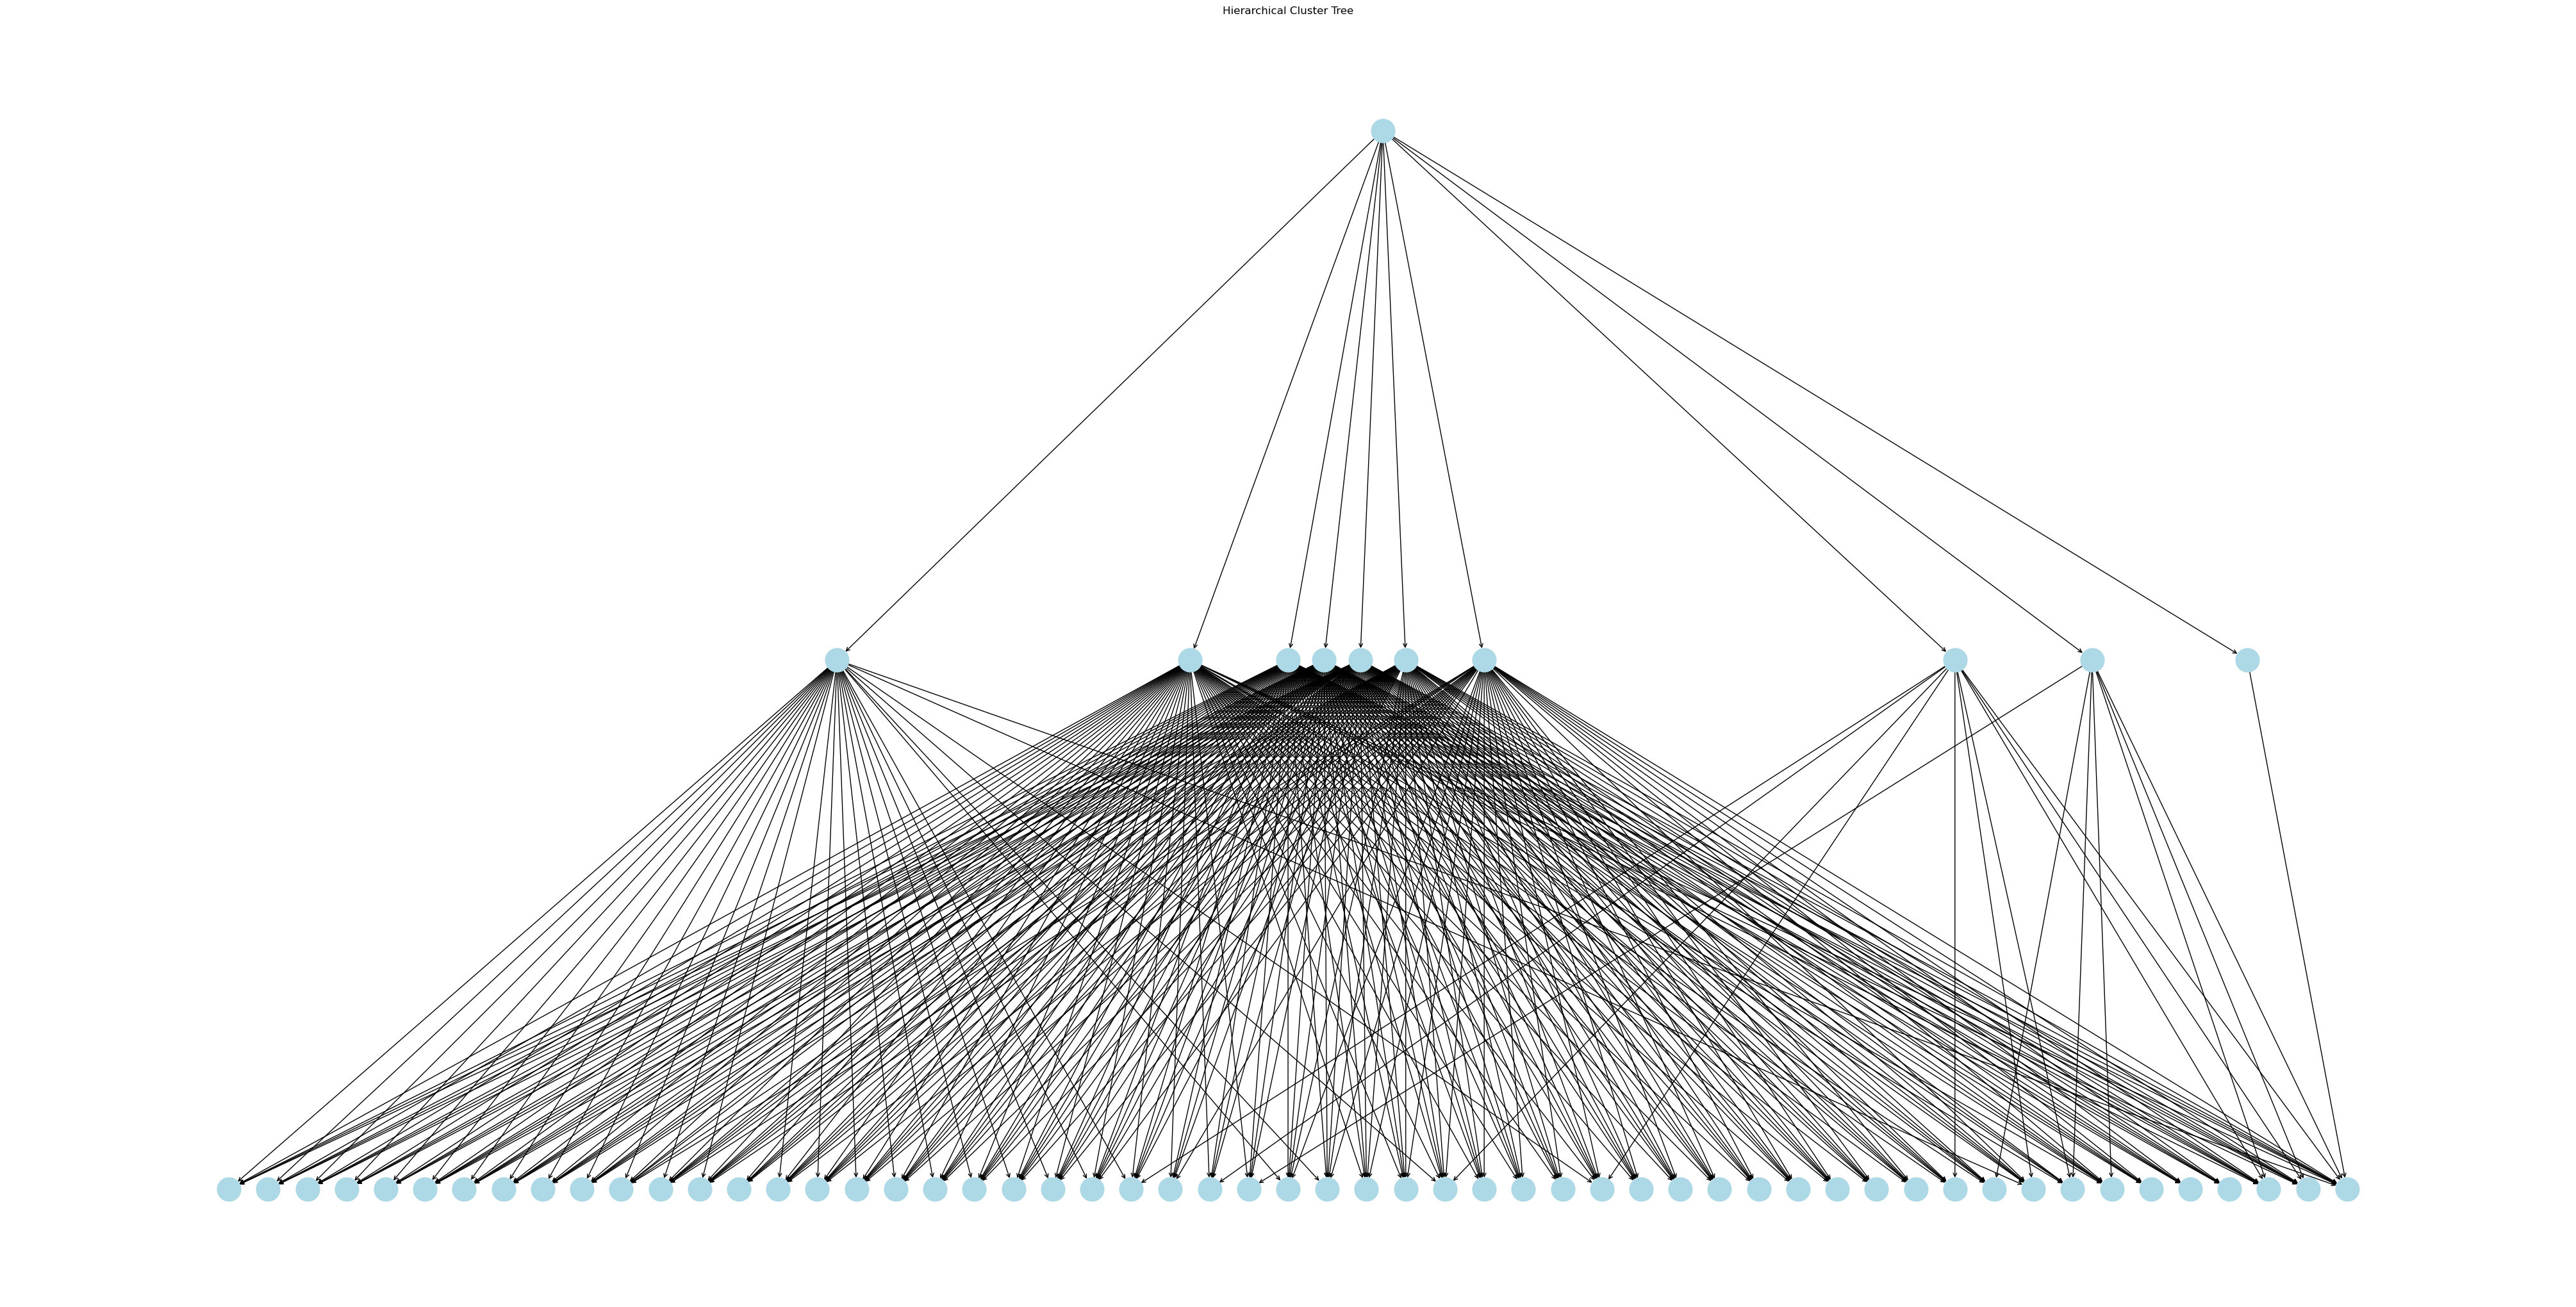

In [25]:
import networkx as nx
# Create a graph
G = nx.DiGraph()

# Step 2: Create nodes for the graph
for res in resolutions:
    for cluster in clusters_genes[res]:
        G.add_node((res, cluster), genes=clusters_genes[res][cluster])

# Step 3: Create edges between nodes
for i in range(len(resolutions) - 1):
    res_i = resolutions[i]
    res_j = resolutions[i + 1]
    for cluster_i in clusters_genes[res_i]:
        genes_i = clusters_genes[res_i][cluster_i]
        for cluster_j in clusters_genes[res_j]:
            genes_j = clusters_genes[res_j][cluster_j]
            if len(genes_j.intersection(genes_i)) / len(genes_j) > 0.9:
                G.add_edge((res_i, cluster_i), (res_j, cluster_j))


# Step 4: Visualize the graph
# Use Graphviz layout for hierarchical tree layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="-Grankdir=TB -Gnodesep=1")

# Plot the graph
plt.figure(figsize=(40, 20))
nx.draw(
    G,
    pos,
    with_labels=False,
    arrows=True,
    node_size=700,
    node_color="lightblue",
    arrowstyle="->",
)

plt.title("Hierarchical Cluster Tree")
plt.axis("off")
plt.show()

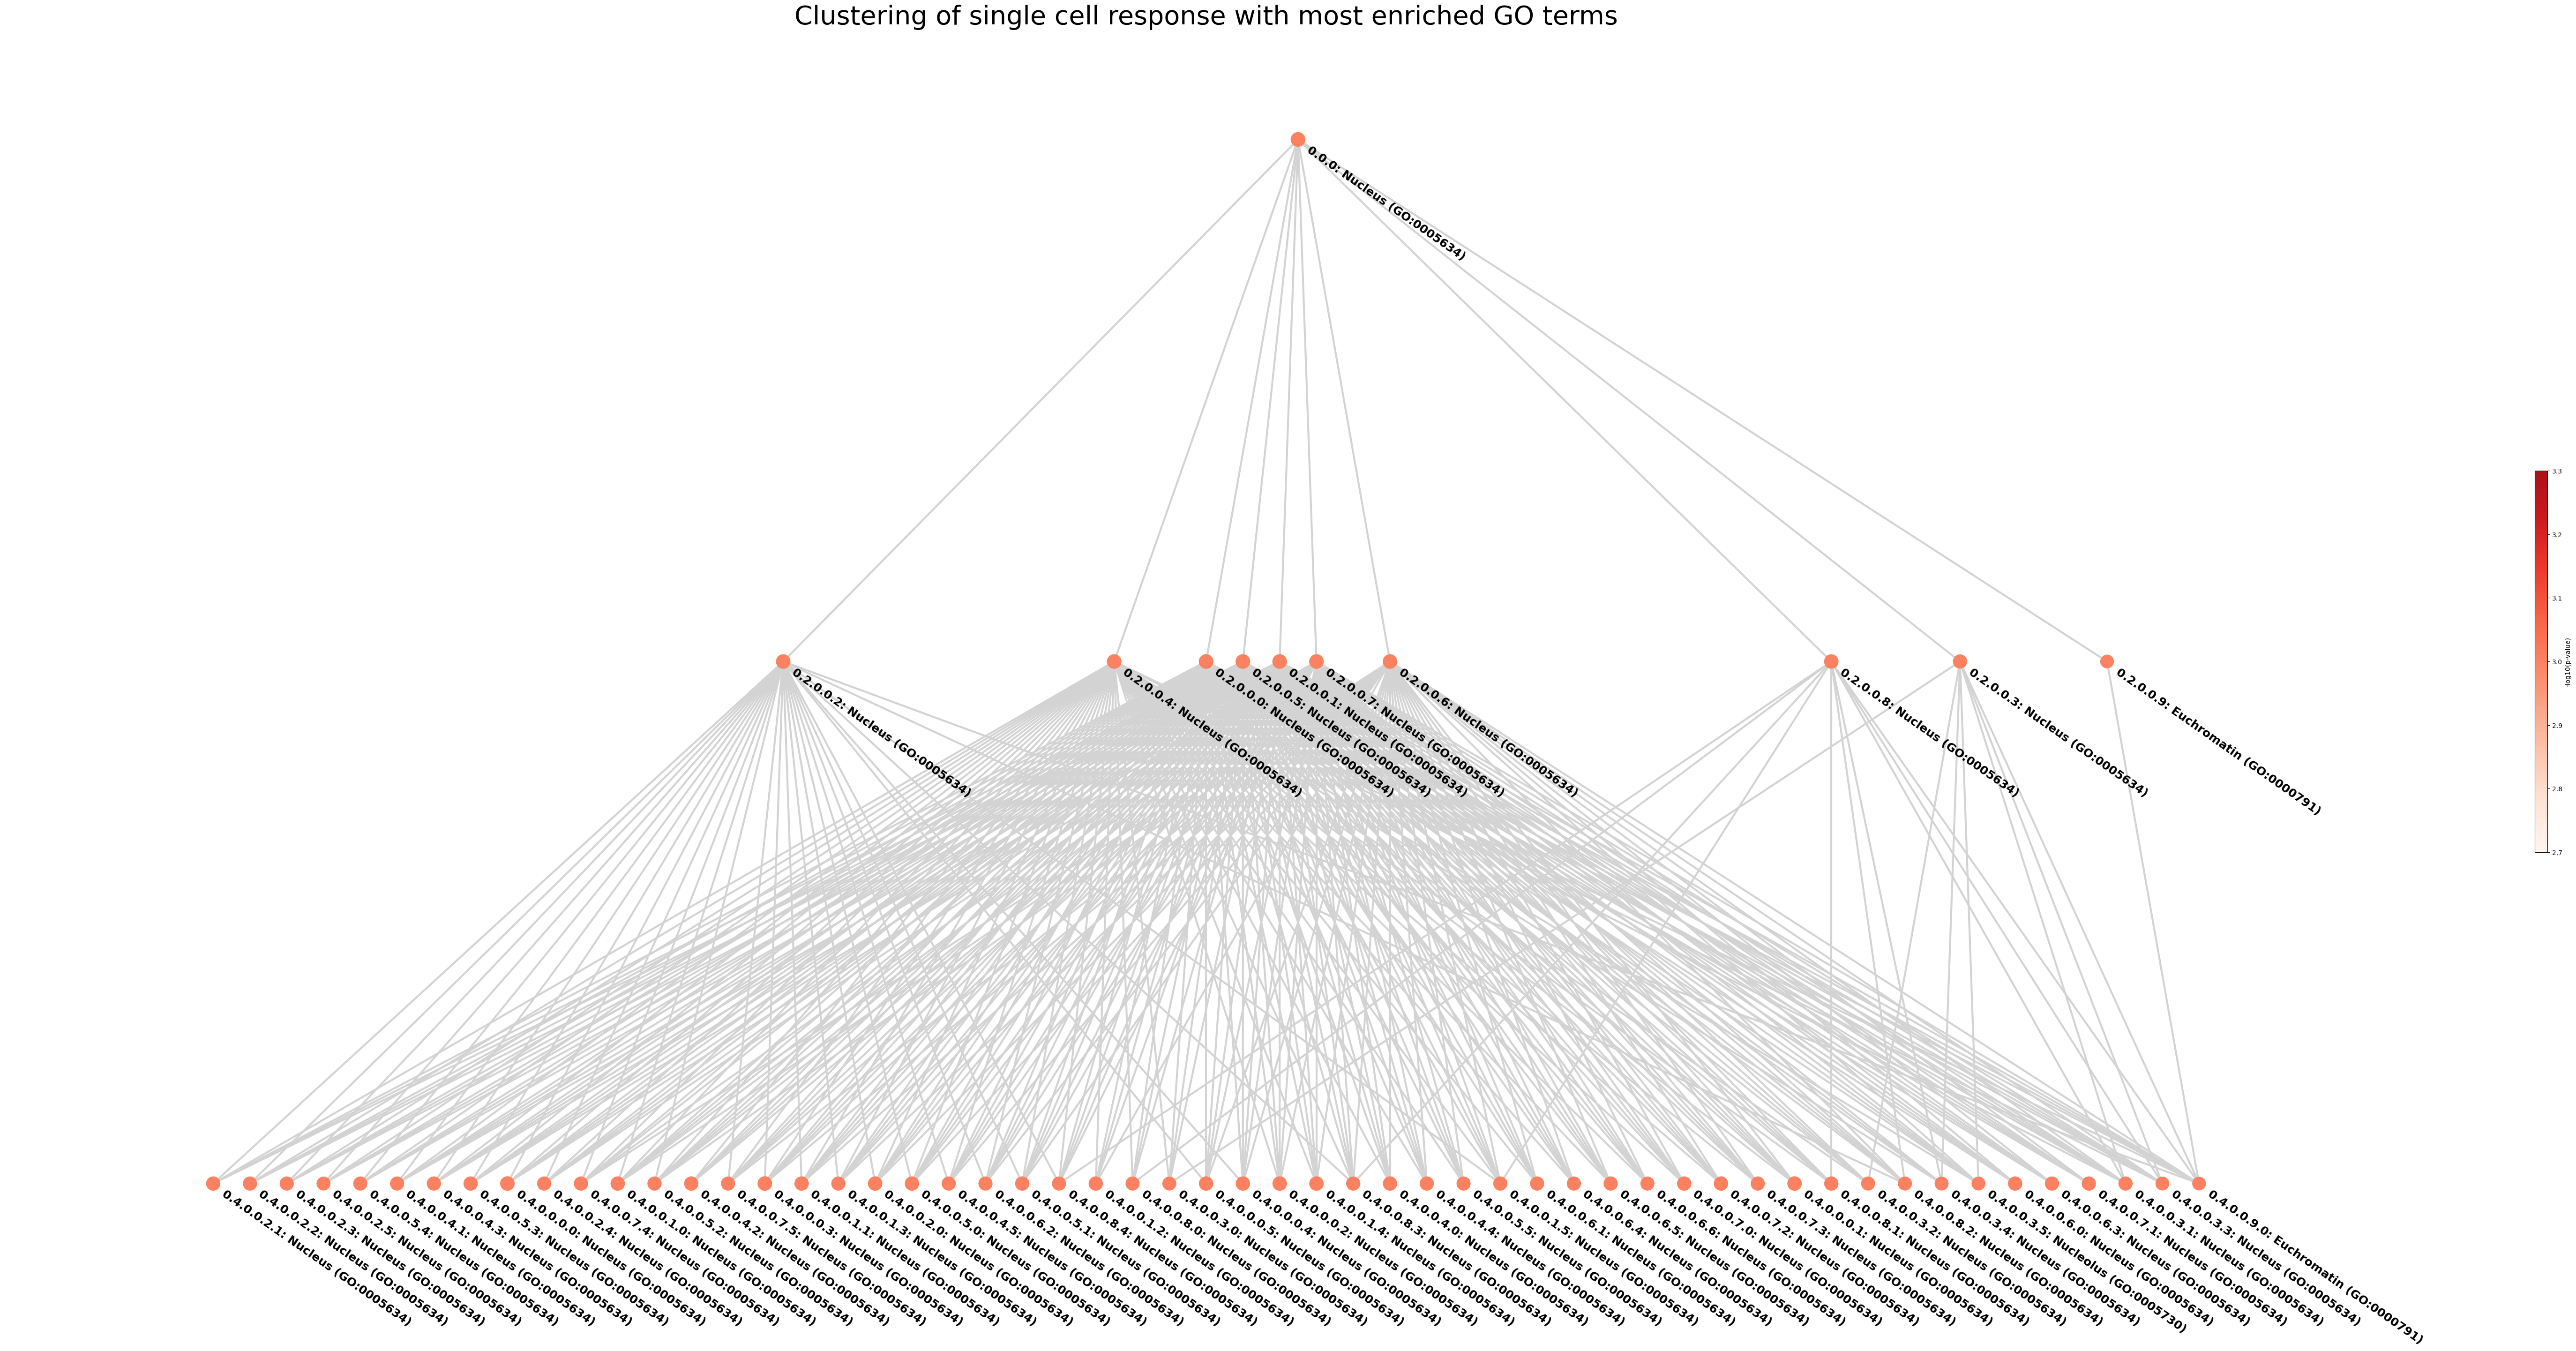

In [26]:
import matplotlib.colors as mcolors
# Adjust the Reds colormap to remove the last 15% of the colors
cmap = plt.get_cmap("Reds")
truncated_cmap = mcolors.LinearSegmentedColormap.from_list(
    "truncated_reds", cmap(np.linspace(0, 0.85, 256))
)

# Create node labels based on the most significant term and calculate node size and color
# level_dict = {0: 1, 0.15: 2, 0.2: 3, 0.25: 4, 0.3: 5, 0.33: 6, 0.36: 7}

node_sizes = []
node_colors = []
label_dict = {}

# Iterate over each node in the graph
for node in G.nodes:
    # Calculate node size based on the number of genes
    num_genes = len(G.nodes[node]["genes"])
    node_sizes.append(400 + num_genes)  # Scale the size for better visualization
    cluster = f"{node[1]}"
    res = node[0]

    # Check if there are enrichment results for the node
    if cluster_enrichments[res][cluster] is not None: # and not cluster_enrichments[res][cluster].empty:
        most_significant_term = cluster_enrichments[res][cluster]

        # Create a label for the node based on the most significant term
        label_dict[node] = most_significant_term
        label = f"  {res}.{cluster}: {most_significant_term}"
        p_value = 0.001 #most_significant_term["p_value"]

        # Calculate node color based on the -log10(p-value)
        node_colors.append((-np.log10(p_value)).clip(0, 50))

    else:
        # If no enrichment, set a default label and color
        label = f"  {res}.{cluster}: -"
        node_colors.append(0)  # No enrichment, set color to 0

    # Set the label for the node
    G.nodes[node]["label"] = label

# Visualize the graph with labels rotated by 45 degrees, node sizes, and colors
# Use Graphviz layout for hierarchical tree layout
pos = nx.nx_agraph.graphviz_layout(
    G, prog="dot", args="-Grankdir=TB -Gnodesep=300 -Granksep=3000"
)
'''
# Manually adjust positions of specific nodes for better visualization
node_to_move = (0.15, "0")
pos[node_to_move] = (pos[node_to_move][0] * 0.85, pos[node_to_move][1])

node_to_move = (0.15, "1")
pos[node_to_move] = (pos[node_to_move][0] * 1.05, pos[node_to_move][1])

node_to_move = (0.2, "0")
pos[node_to_move] = (pos[node_to_move][0] * 0.78, pos[node_to_move][1])

node_to_move = (0.2, "3")
pos[node_to_move] = (pos[node_to_move][0] * 0.93, pos[node_to_move][1])

node_to_move = (0.25, "5")
pos[node_to_move] = (pos[node_to_move][0] * 0.975, pos[node_to_move][1])
'''
# Create a figure for the plot
plt.figure(figsize=(70, 35))

# Draw the nodes with specified sizes and colors
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=truncated_cmap
)

# Draw the edges with a light gray color
edges = nx.draw_networkx_edges(G, pos, edge_color="#D3D3D3", width=3, arrows=False)

# Get the labels for the nodes
labels = nx.get_node_attributes(G, "label")

# Add text labels to the nodes
for key, (x, y) in pos.items():
    plt.text(
        x,
        y,
        labels[key],
        fontsize=18,
        fontweight="bold",
        ha="left",
        va="top",
        rotation=-35,
    )

# Add a colorbar to the plot
plt.colorbar(
    nodes, label="-log10(p-value)", fraction=0.005, location="right", aspect=30
)

# Add a title to the plot
plt.title(
    "Clustering of single cell response with most enriched GO terms",
    fontsize=40,
)

# Remove the axis frame
plt.axis("off")

# Save the plot as an SVG file
plt.savefig(
    f"B2AI_{treatment}_subclustering_hierarchy_graph.svg",
    format="svg",
    bbox_inches="tight",
)

# Display the plot
plt.show()

In [27]:
def plot_scatter_with_labels(data, labels):
    """Create a scatter plot where points are colored based on string class labels."""
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Use a colormap with enough distinct colors
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)  # Find points with the current label
        plt.scatter(data[idx, 0], data[idx, 1], color=colors(i), label=label, s=5)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Class Labels', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
    plt.title('Scatter Plot Colored by Class Labels')
    plt.show()

from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter_with_labels(data, labels):
    """Create a 3D scatter plot with points colored based on string class labels."""
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)  # Find points with the current label
        ax.scatter(data[idx, 0], data[idx, 1], data[idx, 2], 
                   color=colors(i), label=label, s=5)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

    # Add legend and title
    ax.legend(title='Class Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('3D Scatter Plot Colored by Class Labels')
    plt.show()

#plot_scatter_with_labels(reduced_data[np.where(np.array(labels) == 'vorinostat')], np.array(proteins)[np.where(np.array(labels) == 'vorinostat')])
#plot_scatter_with_labels(reduced_data[np.where(np.array(labels) == 'paclitaxel')], np.array(proteins)[np.where(np.array(labels) == 'paclitaxel')])
#plot_3d_scatter_with_labels(reduced_data[np.where(np.array(labels) == 'vorinostat')], np.array(proteins)[np.where(np.array(labels) == 'vorinostat')])
#plot_3d_scatter_with_labels(reduced_data[np.where(np.array(labels) == 'paclitaxel')], np.array(partition.membership)[np.where(np.array(labels) == 'paclitaxel')])
#plot_3d_scatter_with_labels(reduced_data[np.where(np.array(labels) == 'vorinostat')], np.array(partition.membership)[np.where(np.array(labels) == 'vorinostat')])
#plot_3d_scatter_with_labels(reduced_data, np.array(partition.membership))

## Latent factorization
Non-negative Matrix Factorization (NMF) decomposes the data into latent factors, which represent subpopulations of proteins and their patterns of change.

Advantage: NMF finds hidden patterns without enforcing orthogonality, making it better for detecting mixed signals.

Output: NMF provides basis vectors (protein subpopulations) and coefficients (how much each sample contributes to each subpopulation).

In [7]:
from sklearn.decomposition import NMF
alldata = np.concatenate([pilr_d['untreated'], pilr_d['vorinostat'], pilr_d['paclitaxel']])
proteins = proteins_untreated + proteins_vorinostat + proteins_paclitaxel
treatments = ['untreated']*pilr_d['untreated'].shape[0] + ['vorinostat']*pilr_d['vorinostat'].shape[0] + ['paclitaxel']*pilr_d['paclitaxel'].shape[0]
img_ids = shape_d['untreated'].index.tolist() + shape_d['vorinostat'].index.tolist() + shape_d['paclitaxel'].index.tolist()
'''
err = []
for n_components in [5, 10]: # Set number of components (clusters) to extract
    nmf = NMF(n_components=n_components, init='random', random_state=42)
    W = nmf.fit_transform(alldata)  # Sample-to-component matrix
    err.append(nmf.reconstruction_err_)
err
'''
nmf = NMF(n_components=6, init='random', random_state=33)#, solver='mu', beta_loss = 'kullback-leibler')
#nmf = NMF(n_components=6, init='random', random_state=0)#, solver='mu', beta_loss = 'kullback-leibler')
#W = nmf.fit_transform(alldata[np.where(np.array(proteins) == unique_proteins[2])])  # Sample-to-component matrix
W = nmf.fit_transform(alldata)  # Sample-to-component matrix
H = nmf.components_  # Component-to-feature matrix
# Assign cluster labels (based on the highest NMF component score for each sample)
cluster_labels = np.argmax(W, axis=1)
print(f"{nmf.reconstruction_err_}, {cluster_labels}")


/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


17344699.428323112, [5 4 1 ... 0 0 0]


In [8]:
import numpy as np

def assign_clusters_soft(W, threshold=0.5):
    """Assigns clusters based on a threshold of component contributions."""
    normalized_W = W / W.sum(axis=1, keepdims=True)  # Normalize each row to sum to 1
    cluster_labels = [np.where(row >= threshold)[0].tolist() for row in normalized_W]
    return cluster_labels

def assign_clusters_weighted(W):
    """Assigns clusters based on component weight proportions."""
    normalized_W = W / W.sum(axis=1, keepdims=True)
    return normalized_W

cluster_labels_multi = assign_clusters_soft(W, threshold=0.3)
cluster_labels_probab = assign_clusters_weighted(W)
print(cluster_labels_multi, cluster_labels_probab)

[[0, 5], [], [], [], [4], [4], [], [], [], [], [], [], [], [], [], [], [4], [], [], [], [1], [1], [], [1], [], [], [], [0], [], [], [4], [], [], [], [], [], [], [], [4], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [], [1], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [], [], [], [], [], [], [], [1], [], [], [], [], [], [], [0], [], [4], [], [], [5], [], [2], [], [1], [0], [], [1], [1], [1], [1, 2], [1], [1], [1], [1], [1], [5], [4], [5], [], [1], [1], [1], [5], [1], [4], [2, 4], [2], [], [1], [], [2], [1], [1, 5], [1], [0], [1], [1], [1], [1], [], [1, 5], [2], [1], [1], [], [], [], [1], [1], [0], [], [0], [0], [1], [0], [1], [], [0, 1], [1], [], [1], [], [1], [1], [1], [0], [1], [0], [], [], [1], [], [], [1], [1], [], [1], [], [1], [1], [], [0], [0], [0], [], [0], [1], [], [1], [0], [], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0

In [ ]:
#316855.25297777925 > 305388.3742132621 
16892813.211500544 > 16973679.267573874 

False

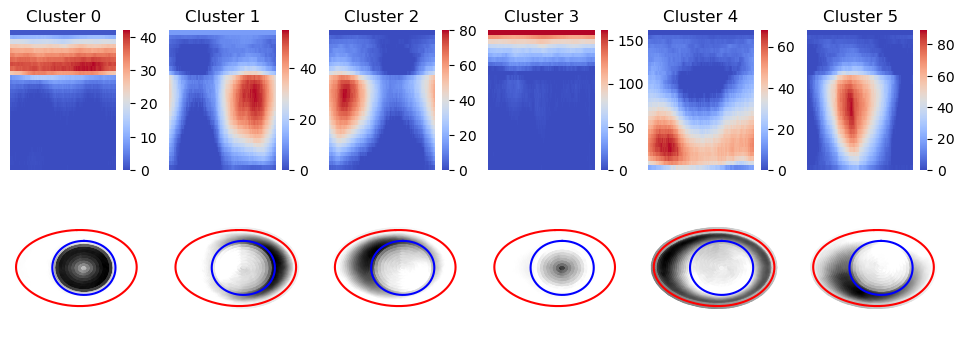

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
avg_cell = np.load(f"{cfg.PROJECT_DIR}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/Avg_cell.npz")
nu_centroid = [0, 0]
ix_n = avg_cell["ix_n"]
iy_n = avg_cell["iy_n"]
ix_c = avg_cell["ix_c"]
iy_c = avg_cell["iy_c"]
# Move average shape from zero-centered coords to min=[0,0]
min_x = np.min(ix_c)
min_y = np.min(iy_c)
nu_centroid[0] -= min_x
nu_centroid[1] -= min_y
ix_n -= min_x
iy_n -= min_y
ix_c -= min_x
iy_c -= min_y

from warps import parameterize
x_, y_ = parameterize.get_coordinates(
    np.concatenate([ix_n, iy_n]), 
    np.concatenate([ix_c, iy_c]), 
    nu_centroid, n_isos=cfg.N_ISOS, plot=False
)
x = np.array(x_).round().astype("uint16")
y = np.array(y_).round().astype("uint16")

# Visualize Feature Contributions per Cluster
#plt.figure(figsize=(10, 6))
#sns.heatmap(H, annot=True, cmap='coolwarm', yticklabels=[f'Cluster {i}' for i in range(n_components)])

def visualize_nmf_components(H, pilr0, ix_n, iy_n, ix_c, iy_c):
    n_col = H.shape[0]
    fig, ax = plt.subplots(ncols=n_col, nrows=2, figsize=(2*n_col, 4))
    for i in range(n_col):
        sns.heatmap(H[i].reshape(pilr0.shape), annot=False, cmap='coolwarm', ax=ax[0,i])
        ax[0,i].axis('off')
        ax[0,i].set_title(f'Cluster {i}')
        ax[1,i].scatter(y.flatten(), x.flatten(), c=H[i], cmap='binary', s=10)    
        ax[1,i].plot(iy_n, ix_n, 'b')
        ax[1,i].plot(iy_c, ix_c, 'r')
        ax[1,i].axis('equal')
        ax[1,i].axis('off')
    
    #plt.title('NMF Feature Contributions by Cluster')
    plt.xlabel('Features')
    #plt.ylabel('NMF Components (Clusters)')
    plt.show()

from imageio import imread
def plot_image_collage(paths, n_cols=5, figsize=(20, 20), globalvmax=None):
    n_rows = len(paths) // n_cols# + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(paths):
            if globalvmax:
                ax.imshow(imread(paths[i]), cmap='inferno', vmax=globalvmax)
            else:
                ax.imshow(imread(paths[i]), cmap='inferno')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

from coefficients.coefs import inverse_fft
def plot_avg_shape(fcoef, ax=None):
    n = 128
    fcoef_c = fcoef[0 : n * 2]
    fcoef_n = fcoef[n * 2 :]
    ix_n, iy_n = inverse_fft(fcoef_n[0 : n], fcoef_n[n :])
    ix_c, iy_c = inverse_fft(fcoef_c[0 : n], fcoef_c[n :])
    if ax:
        ax.plot(ix_n, iy_n)
        ax.plot(ix_c, iy_c)
        ax.axis('scaled')
    else:
        plt.plot(ix_n, iy_n)
        plt.plot(ix_c, iy_c)
        plt.axis('scaled')

        
visualize_nmf_components(H, pilr0, ix_n, iy_n, ix_c, iy_c)

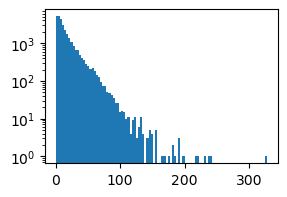

In [32]:
plt.figure(figsize=(3, 2))
plt.hist(W[:,2], bins=100)
plt.yscale('log')

In [10]:
from scipy.ndimage import rotate, center_of_mass
from utils.helpers import get_line
from skimage import exposure

fft_shift_path = f"{cfg.PROJECT_DIR}/fftcoefs/{cfg.ALIGNMENT}/shift_error_meta_fft128.txt"
def rotate_and_pad_to_size(img, angle, final_size=(500, 500), cval=0):
    rotated = rotate(img, angle=angle, reshape=True, order=1, mode='constant', cval=cval)
    h, w = rotated.shape
    target_h, target_w = final_size

    # Pad if smaller
    pad_h = max(target_h - h, 0)
    pad_w = max(target_w - w, 0)
    rotated = np.pad(rotated,
        ((pad_h // 2, pad_h - pad_h // 2),
         (pad_w // 2, pad_w - pad_w // 2)),
        mode='constant', constant_values=cval)
    
    # Crop center if larger
    center_y, center_x = rotated.shape[0] // 2, rotated.shape[1] // 2
    final = rotated[
        center_y - target_h // 2 : center_y + target_h // 2,
        center_x - target_w // 2 : center_x + target_w // 2
    ]
    return final


def rotation_and_align(image_path, shape_path, find_pattern, rescale=False, output_size=(600, 600)):
    """Rotate and align the image based on the shift dictionary, return fixed-size outputs."""

    fft_coefs = get_line(fft_shift_path, search_text=find_pattern, mode="first")
    vals = fft_coefs.strip().split(";") 
    theta = float(vals[1])
    print(find_pattern, fft_coefs, fft_shift_path, vals, theta)

    img = plt.imread(image_path)
    if rescale:
        l, h = np.percentile(img, (0, 100))
        img = exposure.rescale_intensity(img, in_range=(l, h))

    protein_ch = rotate_and_pad_to_size(img, angle=theta, final_size=output_size)
    data = np.load(shape_path)
    nuclei = rotate_and_pad_to_size(data[1, :, :], angle=theta, final_size=output_size)
    cell = rotate_and_pad_to_size(data[0, :, :], angle=theta, final_size=output_size)

    center_cell = center_of_mass(cell)
    center_nuclei = center_of_mass(nuclei)

    if center_cell[1] > center_nuclei[1]:  # rotate 180 if flipped
        protein_ch = rotate_and_pad_to_size(protein_ch.copy(), angle=180, final_size=output_size)
        cell = rotate_and_pad_to_size(cell.copy(), angle=180, final_size=output_size)
        nuclei = rotate_and_pad_to_size(nuclei.copy(), angle=180, final_size=output_size)

    return protein_ch, nuclei, cell


In [46]:
rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                    shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                    find_pattern=f"{ab}/{sampleid}/{cellid[:-4]}.npy")

HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/15.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/15.npy;-115.93499150938122;(249.96636310792482, 256.16837822127496);2.332481471484419;0.7119937398222889
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/15.npy', '-115.93499150938122', '(249.96636310792482, 256.16837822127496)', '2.332481471484419', '0.7119937398222889'] -115.93499150938122


/tmp/ipykernel_477910/2799161293.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))


HPA037708_AURKB/B2AI_1_untreated_G5_R4/45.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA037708_AURKB/B2AI_1_untreated_G5_R4/45.npy;-38.1106768529524;(244.15230133801597, 289.70054163678185);4.01363206769088;1.2137372675123306
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA037708_AURKB/B2AI_1_untreated_G5_R4/45.npy', '-38.1106768529524', '(244.15230133801597, 289.70054163678185)', '4.01363206769088', '1.2137372675123306'] -38.1106768529524
CAB080426_HDAC8/B2AI_1_untreated_A4_R7/3.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080426_HDAC8/B2AI_1_untreated_A4_R7/3.npy;-9.493184239962915;(272.6763049721268, 516.4613435441184);7.707484248165839;2.9368203802134074
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080426_HDAC8/B2AI_1_untreated_A4_R7/3.npy', '-9.49318423

HPA026633_UHRF2/B2AI_1_Vorinostat_D2_R6/4.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026633_UHRF2/B2AI_1_Vorinostat_D2_R6/4.npy;-38.01892799451394;(130.1496703749485, 154.60269880510918);1.3441371695781743;1.9000055539214928
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026633_UHRF2/B2AI_1_Vorinostat_D2_R6/4.npy', '-38.01892799451394', '(130.1496703749485, 154.60269880510918)', '1.3441371695781743', '1.9000055539214928'] -38.01892799451394
HPA022133_53BP1/B2AI_1_untreated_B12_R3/12.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_untreated_B12_R3/12.npy;-179.41910358766683;(207.70472801486173, 270.1806431356132);3.8821301463970346;2.0523271948137167
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_untreated_B12_R3/12.npy'

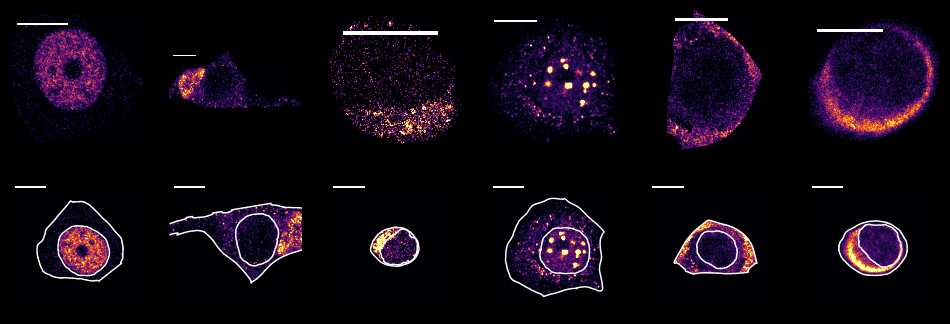

In [30]:
pixel_size = 0.07  # μm/pixel, for B2AI
scale_bar_length_um = 10  # desired length in μm
scale_bar_pixels = int(scale_bar_length_um / pixel_size)
from matplotlib.patches import Rectangle

W_ = np.round(W,2)
W_ /= W_.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(2, 6, figsize=(2*6, 4))
fig.patch.set_facecolor('black')
for i in range(6):
    imgpath = np.array(img_ids)[np.where(W_[:,i] > np.max(W_[:,i])*0.90)][0]
    if i == 5:
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080430_DNMT1/B2AI_1_untreated_A8_R1/30.npy"
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA008445_YWHAE/B2AI_1_Vorinostat_B11_R12/7.npy"
    img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))

    ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
    rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                    shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                    find_pattern=f"{ab}/{sampleid}/{cellid[:-4]}.npy")
    ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
    ax[0, i].axis('off') 

    # Draw white rectangle scale bar in bottom left corner
    scale_bar = Rectangle(
        (20, img.shape[0] - 30),  # x, y: start near bottom-left
        width=scale_bar_pixels,  # 10 µm in pixel units
        height=6,
        linewidth=0,
        edgecolor=None,
        facecolor='white'
    )
    ax[0, i].add_patch(scale_bar)
    

    ax[1, i].imshow(rotated_img, origin='lower', cmap='inferno', vmin=np.percentile(rotated_img, 10), vmax=np.percentile(rotated_img, 99))
    ax[1, i].contour(cell_mask > 0, colors='white', linewidths=1, alpha=1)
    ax[1, i].contour(nuclei_mask > 0, colors='white', linewidths=1, alpha=1)
    ax[1, i].axis('off')

    # Draw white rectangle scale bar in bottom left corner
    scale_bar = Rectangle(
        (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
        width=scale_bar_pixels,  # 10 µm in pixel units
        height=6,
        linewidth=0,
        edgecolor=None,
        facecolor='white'
    )
    ax[1, i].add_patch(scale_bar)
    

In [26]:
np.array(img_ids)[np.where(W_[:,i] > np.max(W_[:,i])*0.60)]

array(['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080430_DNMT1/B2AI_1_untreated_A8_R1/30.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA061646_BRD4/B2AI_1_untreated_B10_R5/33.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA035409_PRKAA1/B2AI_1_untreated_B7_R5/14.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA008445_YWHAE/B2AI_1_Vorinostat_B11_R12/7.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA051773_BRE1A/B2AI_1_Paclitaxel_G1_R4/23.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA021152_PDP1/B2AI_1_Paclitaxel_F12_R2/21.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA067142_ATM/B2AI_1_Paclitaxel_F5_R2/34.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080426_HDAC8/B2AI_1_Paclitaxel_A4_R16/6.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_Paclitaxel_B12_R1/5.npy',
       '/scratch/users

/tmp/ipykernel_76731/2803497925.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))


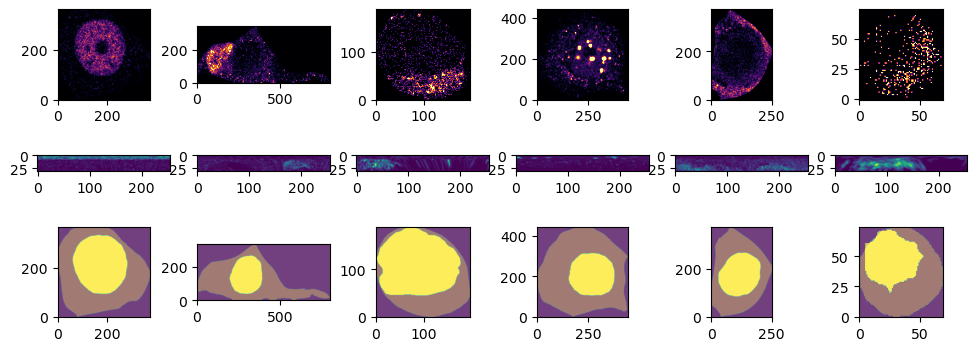

In [11]:
W_ = np.round(W,2)
W_ /= W_.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(3, 6, figsize=(2*6, 4))
for i in range(6):
    imgpath = np.array(img_ids)[np.where(W_[:,i] > np.max(W_[:,i])*0.9 )][0]
    if i == 5:
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080430_DNMT1/B2AI_1_untreated_A8_R1/30.npy"
        imgpath = "/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_Paclitaxel_B12_R1/5.npy"
    img = imread(imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'))
    ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
    ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
    pilr_path = f'/data/2Dshapespace/B2AI/sampled_intensity_bin/{ab}_{sampleid}_{cellid[:-4]}_protein.npy'
    ax[1, i].imshow(np.load(pilr_path))
    data = np.load(imgpath.replace('/scratch/users/tle1302','/data'))
    ax[2, i].imshow(data[0,:,:], alpha=0.5, origin='lower')
    ax[2, i].imshow(data[1,:,:], alpha=0.5, origin='lower')
    

In [ ]:
np.array(img_ids)[np.where(W_[:,i] > np.max(W_[:,i])*0.7)]


array(['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080430_DNMT1/B2AI_1_untreated_A8_R1/30.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA051773_BRE1A/B2AI_1_Paclitaxel_G1_R4/23.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/CAB080426_HDAC8/B2AI_1_Paclitaxel_A4_R16/6.npy',
       '/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA022133_53BP1/B2AI_1_Paclitaxel_B12_R1/5.npy'],
      dtype='<U112')

Reconstruction error A: 21574.45789946876
Reconstruction error B: 6958.177085039821


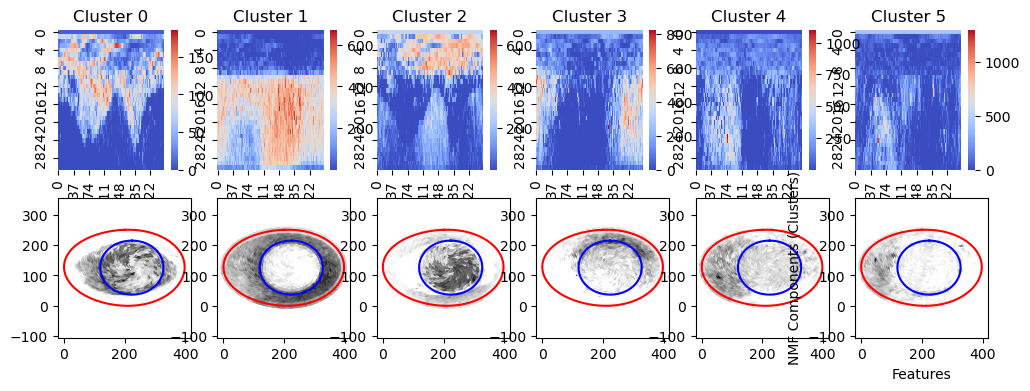

In [ ]:
unique_proteins = np.unique(proteins) 
data_untreated = pilr_d['untreated'][np.where(np.array(proteins_untreated) == unique_proteins[3])]
data_vorinostat = pilr_d['vorinostat'][np.where(np.array(proteins_vorinostat) == unique_proteins[3])]

# Assuming X_A and X_B are your datasets for conditions A and B
n_components = 6 #min(X_A.shape[1], X_B.shape[1])  # or a smaller number

nmf_A = NMF(n_components=n_components, random_state=45, solver='mu', beta_loss = 'kullback-leibler')
W_A = nmf_A.fit_transform(data_untreated)
H_A = nmf_A.components_

nmf_B = NMF(n_components=n_components, random_state=45, solver='mu', beta_loss = 'kullback-leibler')
W_B = nmf_B.fit_transform(data_vorinostat)
H_B = nmf_B.components_
print(f"Reconstruction error A: {nmf_A.reconstruction_err_}")
print(f"Reconstruction error B: {nmf_B.reconstruction_err_}")

visualize_nmf_components(H_A, pilr0, ix_n, iy_n, ix_c, iy_c)

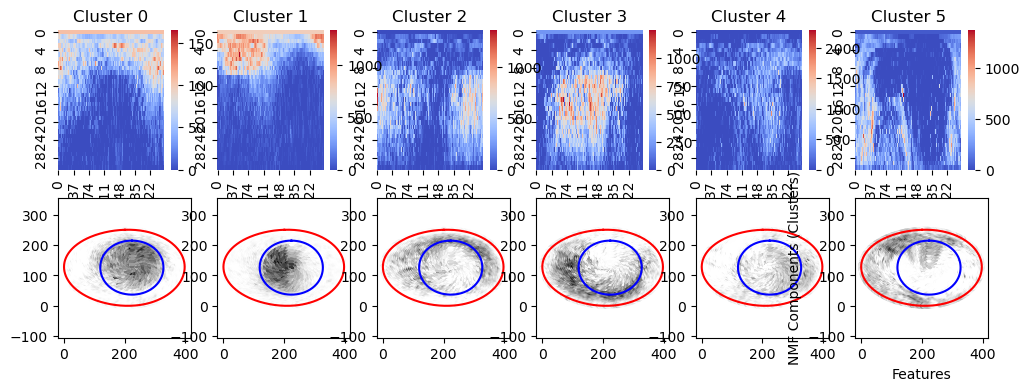

In [ ]:
visualize_nmf_components(H_B, pilr0, ix_n, iy_n, ix_c, iy_c)

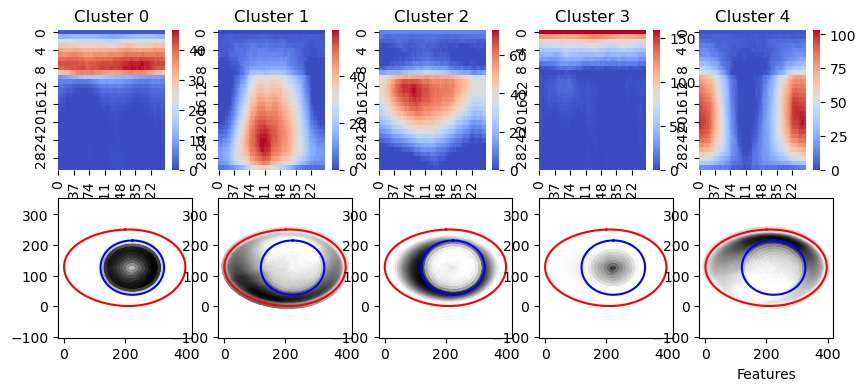

# Measure of translocation!

TODO:
- elbow to get the best n_component (done, gradually decrease but distinction can be made at around 4 components. Choose 6 because it gives the best output)
- check whole image for translocation events (eg. many locations for untreated, but 1 location for treated) (done)
- check if groupify it according to shapespace can increase effect (at certain shape, there is a clear shift from 1 organelle to another)

In [12]:
from scipy.stats import wasserstein_distance
#clustermix = pd.DataFrame(W)
unique_proteins = np.unique(proteins)
wd_treatment = []
for protein_name in unique_proteins:
    #protein_name = unique_proteins[10]
    W_ = np.round(W,2)[np.where(np.array(proteins) == protein_name)]
    W_ /= W_.sum(axis=1, keepdims=True)
    clustermix = pd.DataFrame(W_)
    clustermix['Cluster'] = cluster_labels[np.where(np.array(proteins) == protein_name)]
    clustermix['Proteins'] = protein_name #proteins[np.where(np.array(proteins) == 'HPA019662_HDAC10')]
    clustermix['Treatment'] = np.array(treatments)[np.where(np.array(proteins) == protein_name)[0]]
    clustermix['Image'] = np.array(img_ids)[np.where(np.array(proteins) == protein_name)[0]]

    pivot_df0 = clustermix[[0,1,2,3,4,5,'Treatment']].groupby('Treatment').mean()
    pivot_df0 = pivot_df0.div(pivot_df0.sum(axis=1), axis=0)

    pivot_df = clustermix.groupby(["Treatment", "Cluster"]).size().unstack(fill_value=0)
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
    #pivot_df.plot(kind='barh', stacked=True, figsize=(4, 2))
    wd_treatment.append([protein_name, 
                         wasserstein_distance(pivot_df.T.untreated, pivot_df.T.vorinostat), 
                         wasserstein_distance(pivot_df.T.untreated, pivot_df.T.paclitaxel),
                         wasserstein_distance(pivot_df0.T.untreated, pivot_df0.T.vorinostat),
                         wasserstein_distance(pivot_df0.T.untreated, pivot_df0.T.paclitaxel)])
    
wd_treatment = pd.DataFrame(wd_treatment, columns=['Protein', 'untreated_vorinostat', 'untreated_paclitaxel', 'untreated_vorinostat_fractional', 'untreated_paclitaxel_fractional'])

In [13]:
pivot_df0 = clustermix[[0,1,2,3,4,5,'Treatment']].groupby('Treatment').mean()
pivot_df0 = pivot_df0.div(pivot_df0.sum(axis=1), axis=0)

In [19]:
pivot_df, pivot_df0

(Cluster            0         1         2         4         5
 Treatment                                                   
 paclitaxel  0.613139  0.291971  0.014599  0.058394  0.021898
 untreated   0.402299  0.367816  0.045977  0.120690  0.063218
 vorinostat  0.088889  0.577778  0.044444  0.177778  0.111111,
                    0         1         2         3         4         5
 Treatment                                                             
 paclitaxel  0.268096  0.219039  0.134404  0.085995  0.149578  0.142887
 untreated   0.192749  0.253857  0.137220  0.052365  0.207409  0.156400
 vorinostat  0.194578  0.251443  0.149790  0.067480  0.181904  0.154804)

In [ ]:
wd_treatment.sort_values('untreated_vorinostat_fractional', ascending=False).head(10)

Protein  untreated_vorinostat  untreated_paclitaxel  \
38  HPA026588_DNMT3A              0.104987              0.069899   
44   HPA028926_HDAC9              0.218929              0.215817   
9     HPA001023_PHF6              0.240225              0.193796   
69   HPA051773_BRE1A              0.194915              0.141069   
10    HPA001075_TAF1              0.235294              0.226692   
27    HPA012008_CHD4              0.202600              0.116119   
31    HPA021152_PDP1              0.150173              0.051286   
21   HPA006104_KAT6B              0.114286              0.008163   
64    HPA048340_BRG1              0.117197              0.025804   
2    CAB080425_KAT2A              0.041176              0.012500   

    untreated_vorinostat_fractional  untreated_paclitaxel_fractional  
38                         0.142283                         0.109305  
44                         0.116156                         0.111997  
9                          0.085690                         0.062310  
69                         0.079730                         0.055883  
10                         0.079587                         0.094418  
27                         0.069393                         0.058021  
31                         0.065132                         0.035118  
21                         0.063946                         0.020669  
64                         0.060551                         0.008027  
2                          0.057220                         0.028914

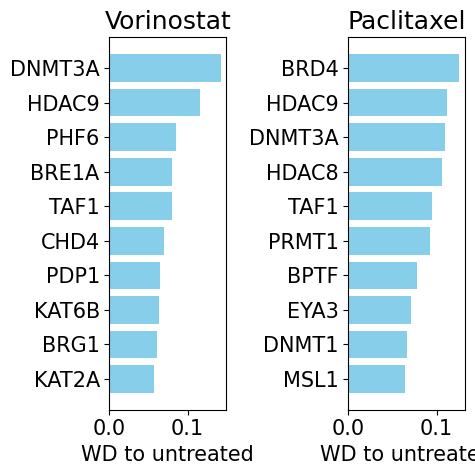

In [34]:
# Sorting and selecting top 10 proteins based on each condition
wd_treatment['Protein_name'] = [f.split('_')[1] for f in wd_treatment.Protein]
df_vorinostat = wd_treatment.sort_values(by="untreated_vorinostat_fractional", ascending=False).head(10)
df_paclitaxel = wd_treatment.sort_values(by="untreated_paclitaxel_fractional", ascending=False).head(10)

plt.rcParams['font.size'] = 15
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Vorinostat barplot
axes[0].barh(df_vorinostat["Protein_name"], df_vorinostat["untreated_vorinostat_fractional"], color='skyblue')
axes[0].set_xlabel("WD to untreated")
axes[0].set_title("Vorinostat")
axes[0].invert_yaxis()  # Highest values on top

# Paclitaxel barplot
axes[1].barh(df_paclitaxel["Protein_name"], df_paclitaxel["untreated_paclitaxel_fractional"], color='skyblue')
axes[1].set_xlabel("WD to untreated")
axes[1].set_title("Paclitaxel")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

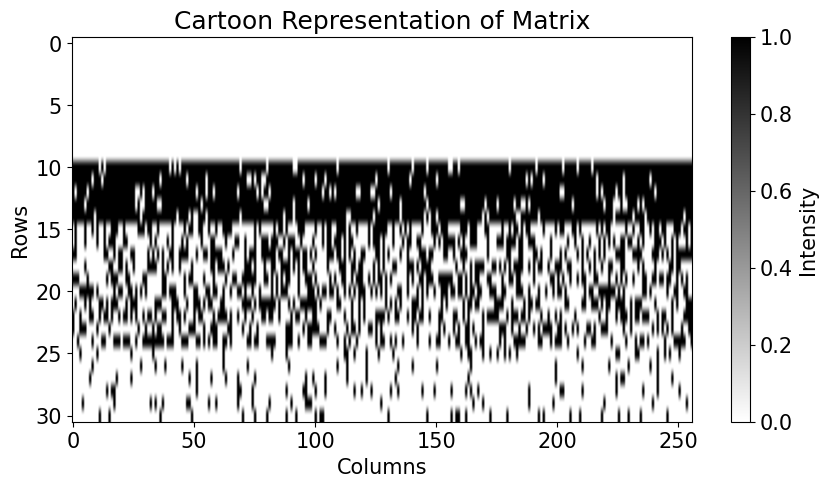

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define matrix size
rows, cols = 31, 256
matrix = np.zeros((rows, cols))

# Assign different concentration levels
matrix[10:20, :] = np.random.choice([0, 1], size=(10, cols), p=[0.1, 0.9])  # High concentration of 1s
matrix[15:30, :] = np.random.choice([0, 1], size=(15, cols), p=[0.6, 0.4])  # Lower gradient concentration
matrix[25:, :] = np.random.choice([0, 1], size=(6, cols), p=[0.9, 0.1])  # Very low concentration

# Plot with reversed grayscale colormap
plt.figure(figsize=(10, 5))
plt.imshow(matrix, cmap='gray_r', aspect='auto')  # Reversed grayscale
plt.colorbar(label="Intensity")
plt.title("Cartoon Representation of Matrix")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


In [ ]:
#wd_treatment[wd_treatment.Protein == 'HPA045168_ARTD1']
W.a

array([[0.25686947, 0.16776305, 0.21604608, 0.12955211, 0.07295962,
        0.15680967],
       [0.23957558, 0.12858668, 0.28411995, 0.19338143, 0.09539676,
        0.0589396 ],
       [0.3269434 , 0.127009  , 0.17759394, 0.17416815, 0.10073253,
        0.09355297],
       ...,
       [0.22028226, 0.2603909 , 0.07662835, 0.16833988, 0.07347592,
        0.20088268],
       [0.19737562, 0.26592926, 0.15880893, 0.20120284, 0.09471338,
        0.08196997],
       [0.20346183, 0.2420104 , 0.17070944, 0.12334749, 0.09452539,
        0.16594545]])

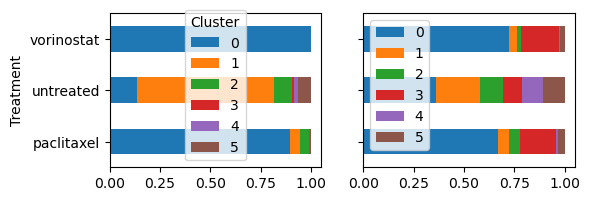

In [31]:
protein_name = 'HPA026588_DNMT3A' # untreated all locations, vorinostat -> just nucleus
#protein_name = "HPA001023_PHF6"#"HPA061646_BRD4"#"HPA026588_DNMT3A"#"HPA006104_KAT6B"#"HPA023567_MSL1"#"HPA061646_BRD4"#"HPA021152_PDP1"
clustermix = pd.DataFrame(W[np.where(np.array(proteins) == protein_name)])
clustermix['Cluster'] = cluster_labels[np.where(np.array(proteins) == protein_name)]
clustermix['Proteins'] = protein_name #proteins[np.where(np.array(proteins) == 'HPA019662_HDAC10')]
clustermix['Treatment'] = np.array(treatments)[np.where(np.array(proteins) == protein_name)[0]]
clustermix['Image'] = np.array(img_ids)[np.where(np.array(proteins) == protein_name)[0]]

fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True, sharey=True)
pivot_df = clustermix.groupby(["Treatment", "Cluster"]).size().unstack(fill_value=0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
pivot_df.plot(kind='barh', stacked=True, ax=ax[0])

pivot_df0 = clustermix[[0,1,2,3,4,5,'Treatment']].groupby('Treatment').mean()
pivot_df0 = pivot_df0.div(pivot_df0.sum(axis=1), axis=0)
pivot_df0.plot(kind='barh', stacked=True, ax=ax[1])
plt.legend()

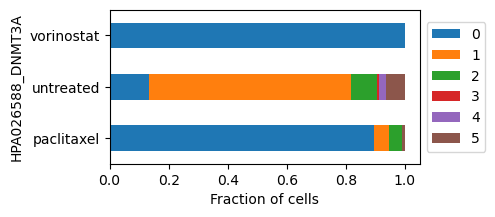

In [35]:
#pilr_d['untreated'][0].max(), pilr_d['vorinostat'][0].max(), pilr_d['paclitaxel'][0].max()
#clustermix[(clustermix.Cluster == 0) & (clustermix.Treatment == 'vorinostat')]
#clustermix[(clustermix.Treatment == 'vorinostat')].Cluster.value_counts()
pivot_df = clustermix.groupby(["Treatment", "Cluster"]).size().unstack(fill_value=0)
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
pivot_df.plot(kind='barh', stacked=True, xlabel='Fraction of cells', ylabel=protein_name, figsize=(4, 2))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

/tmp/ipykernel_477910/3940950016.py:57: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imread(paths[i]), cmap='inferno', vmax=globalvmax)


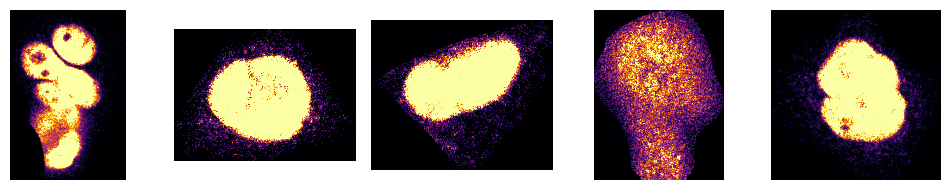

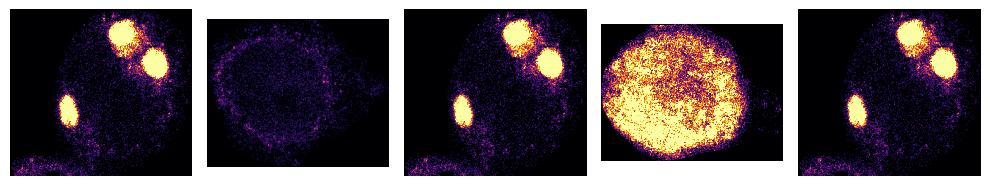

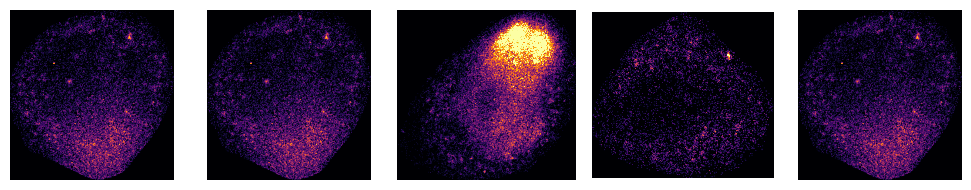

Cluster 3 not found
Cluster 4 not found


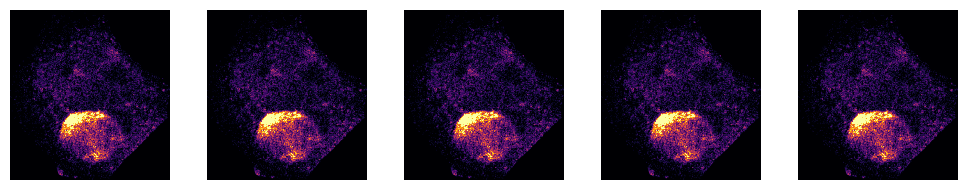

In [33]:
#from analysis.organelle_heatmap_helpers import plot_image_collage
global_max = 10000 #pilr_d['untreated'].max()

for i in range(6):
    try:
        imglist = clustermix[(clustermix.Cluster == i) & (clustermix.Treatment == 'paclitaxel')].sample(5, replace=True).Image.tolist()#[:5]
        if len(imglist) == 0:
            continue
        imglist = [f.replace('/scratch/users/tle1302/2Dshapespace','/data/2Dshapespace').replace('.npy','_protein.png') for f in imglist]
        plot_image_collage(imglist, n_cols=5, figsize=(10,2), globalvmax=global_max)
    except:
        print(f"Cluster {i} not found")

HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R7/12.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R7/12.npy;-162.56826473693934;(208.26701992501006, 189.71853986551392);2.0332481928425192;1.5943105073853783
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R7/12.npy', '-162.56826473693934', '(208.26701992501006, 189.71853986551392)', '2.0332481928425192', '1.5943105073853783'] -162.56826473693934
HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/6.npy /scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8_R4/6.npy;-179.8747014481452;(170.25015014156205, 241.76229015929306);11.139212833666324;4.559319226973605
 /data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/HPA026588_DNMT3A/B2AI_1_Paclitaxel_B8

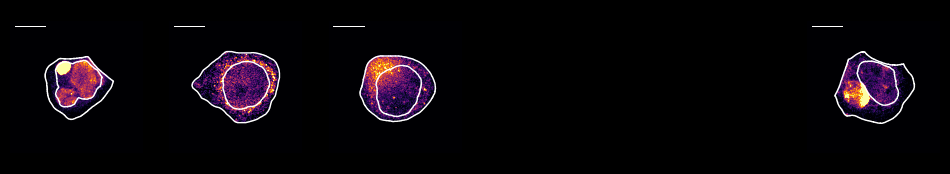

In [45]:
fig, ax = plt.subplots(1, 6, figsize=(2*6, 2))
fig.patch.set_facecolor('black')

for i in range(6):
    try:
        imglist = clustermix[(clustermix.Cluster == i) & (clustermix.Treatment == 'paclitaxel')].sample(2, replace=True).Image.tolist()#.sample(2, replace=True).Image.tolist()
        #if len(imglist) == 0:
        #    continue
        #imglist = [f.replace('/scratch/users/tle1302/2Dshapespace','/data/2Dshapespace').replace('.npy','_protein.png') for f in imglist]
        imgpath = imglist[0]
        ab, sampleid, cellid = imgpath.replace('/scratch/users/tle1302/2Dshapespace/B2AI/cell_masks/', '').split('/')
        rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                        shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                        find_pattern=f"{ab}/{sampleid}/{cellid[:-4]}.npy")
        #ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
        #ax[0, i].axis('off') 
        ax[i].imshow(rotated_img, origin='lower', cmap='inferno', vmin=np.percentile(rotated_img, 15), vmax=np.percentile(rotated_img, 99))
        ax[i].contour(cell_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].contour(nuclei_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].axis('off')
    except:
        print(f"Cluster {i} not found")
        #ax[1,i].imshow(np.zeros((128,128)), vmin=10, vmax=20)
        ax[i].axis('off')
    
    # Draw white rectangle scale bar in bottom left corner
    scale_bar = Rectangle(
        (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
        width=scale_bar_pixels,  # 10 µm in pixel units
        height=6,
        linewidth=0,
        edgecolor=None,
        facecolor='white'
    )
    ax[i].add_patch(scale_bar)

/tmp/ipykernel_26514/2989732681.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax[1].imshow(imread(imglist[0]), origin='lower', cmap='inferno', vmax=global_max)
/tmp/ipykernel_26514/2989732681.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax[3].imshow(imread(imglist[1]), origin='lower', cmap='inferno', vmax=global_max)


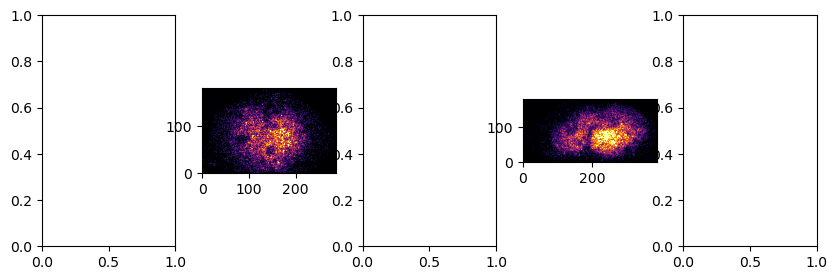

In [ ]:
from imageio import imread
fig, ax = plt.subplots(1,5, figsize=(10,3))#, sharex=True, sharey=True)
#plot_avg_shape(shape_d[].mean().values, ax=ax[0])
ax[1].imshow(imread(imglist[0]), origin='lower', cmap='inferno', vmax=global_max)
#plot_avg_shape(df[df.index==b2_cells[11]].mean().values, ax=ax[2])
ax[3].imshow(imread(imglist[1]), origin='lower', cmap='inferno', vmax=global_max)
#plot_avg_shape(df.mean().values, ax=ax[4])


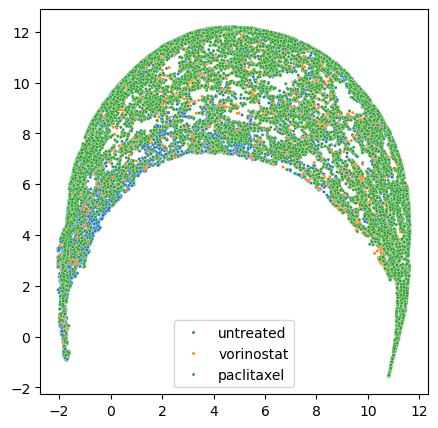

In [ ]:
embedding_all = run_and_plot_umap(W, treatments)

ValueError: Could not interpret value `untreated` for `hue`. Value is a string, but `data` was not passed.

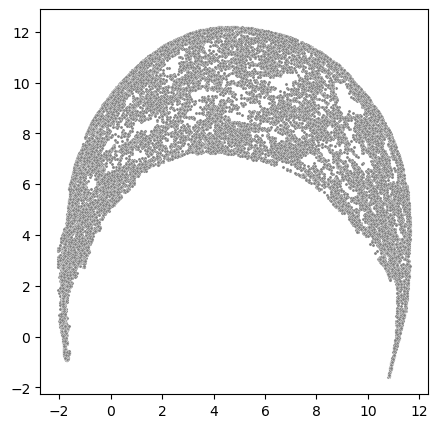

In [ ]:
protein = 'HPA048340_BRG1'
#protein = 'HPA021152_PDP1'
#protein = 'HPA011727_HDAC2'

plt.figure(figsize=(5,5))
sns.scatterplot(x = embedding_all[:,0], y = embedding_all[:,1], c='gray', s=5) #hue=labels_df.Proteins, s=5)
sns.scatterplot(x = embedding_all[proteins == protein, 0], 
                y = embedding_all[proteins == protein, 1], 
                hue = treatments[proteins == protein], s=5)
plt.legend('')

In [ ]:
import seaborn as sns
if False:
    treatment_palette = sns.color_palette("Set2", len(set(labels)))
    treatment_colors = {label: color for label, color in zip(set(labels), treatment_palette)}

    # Optional: Create a clustermap for hierarchical clustering
    sns.clustermap(
        np.array(diff),  # Transpose for clustering
        cmap='viridis',
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Component Score'},
        row_colors=[treatment_colors[label] for label in labels],  # Row colors by treatment
        figsize=(12, 10)
    )

    plt.title('Clustermap of Sample-to-Component Matrix (NMF)')
    plt.show()

In [ ]:
def run_and_plot_umap(alldata, labels):
    reducer=umap.UMAP(n_neighbors=100, min_dist= 1, n_components=3, metric='cosine')
    embedding = reducer.fit_transform(alldata)
    plt.figure(figsize=(5,5))
    sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue=labels, s=5)
    return embedding
alldata = np.concatenate([pilr_d['untreated'], pilr_d['vorinostat'], pilr_d['paclitaxel']])
alldata = reduce_dimensionality(alldata, method='pca', n_components=50)
labels_df = pd.DataFrame({'Proteins':  proteins_untreated + proteins_vorinostat + proteins_paclitaxel, 
                          'Treatments': ['untreated']*pilr_d['untreated'].shape[0] + ['vorinostat']*pilr_d['vorinostat'].shape[0] + ['paclitaxel']*pilr_d['paclitaxel'].shape[0]})
embedding_all = run_and_plot_umap(alldata, labels_df.Treatments)
labels_df['UMAP1'] = embedding_all[:,0]
labels_df['UMAP2'] = embedding_all[:,1]


NameError: name 'reduce_dimensionality' is not defined

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(x = embedding_all[:,0], y = embedding_all[:,1], c= 'gray', s=5, alpha=0.5)
#sns.scatterplot(x = embedding_all[:pilr_d['paclitaxel'].shape[0],0], y = embedding_all[:pilr_d['paclitaxel'].shape[0],1], c='blue', s=5, alpha=0.1)
#sns.scatterplot(x = embedding_all[:pilr_d['vorinostat'].shape[0],0], y = embedding_all[:pilr_d['vorinostat'].shape[0],1], c='blue', s=5, alpha=0.1)
sns.scatterplot(x = embedding_all[:pilr_d['untreated'].shape[0],0], y = embedding_all[:pilr_d['untreated'].shape[0],1], c='blue', s=5, alpha=0.1)

In [ ]:
protein = 'HPA048340_BRG1'
#protein = 'HPA021152_PDP1'
#protein = 'HPA011727_HDAC2'

plt.figure(figsize=(5,5))
sns.scatterplot(x = embedding_all[:,0], y = embedding_all[:,1], c='gray', s=5) #hue=labels_df.Proteins, s=5)
sns.scatterplot(x = embedding_all[labels_df.Proteins == protein, 0], 
                y = embedding_all[labels_df.Proteins == protein, 1], 
                hue = labels_df[labels_df.Proteins == protein].Treatments, s=5)
plt.legend('')

In [ ]:
labels_df.Proteins.unique()

In [ ]:
# shapematched difference
embedding_treated = run_and_plot_umap(np.array(diff[np.array(labels=='vorinostat')]), proteins[labels=='vorinostat'])
plt.legend('')

In [ ]:
np.where(labels=='vorinostat')

In [ ]:
plt.figure(figsize=(5,5))
sns.scatterplot(x = embedding_treated[:,0], y = embedding_treated[:,1], hue=labels, s=5)
plt.legend('')

In [ ]:
embedding_treated2 = umap.UMAP().fit_transform(np.array(diff), y=proteins)

plt.figure(figsize=(5,5))
sns.scatterplot(x = embedding_treated2[:,0], y = embedding_treated2[:,1], hue=labels, s=5)
plt.legend('')

In [ ]:
import pandas as pd
locations = pd.read_csv(f"{cfg.PROJECT_DIR}/location_comparison.csv")
locations['Protein'] = ['_'.join(f.split('_')[:2]) for f in locations.id]
locations['treatment'] = [f.split('_')[-3] for f in locations.id]
locations.groupby(['Protein', 'treatment']).agg('annotations').count().unstack().plot(kind='bar', figsize=(10, 3))
locations['Gene'] = [f.split('_')[1] for f in locations.Protein]

In [ ]:
locations.groupby(['Protein', 'treatment']).agg('annotations')

In [ ]:
errors = []
components = range(1, 10 + 1, 2)

for n in components:
    model = NMF(n_components=n, init='random', random_state=42, max_iter=200)
    W = model.fit_transform(alldata)  # Sample-to-component matrix
    #H = model.components_
    #reconstruction = np.dot(W, H)
    #error = np.linalg.norm(alldata - reconstruction, 'fro')  # Frobenius norm
    #print(f"n_components={n}, error={error}, reconstruction_error {model.reconstruction_err_}")
    #errors.append(error)
    errors.append(model.reconstruction_err_)
# Plot the reconstruction error
plt.plot(components, errors, marker='o', linestyle='-')
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Reconstruction Error (Frobenius Norm)")
plt.title("Choosing Best n_components for NMF")
plt.show()